## 07-1 다중 분류 신경망을 만듭니다

In [1]:
import numpy as np

In [36]:
class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units
        self.batch_size = batch_size
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def forpass(self, x):
        z1 = np.dot(x, self.w1) +self.b1
        self.a1 = self.sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) +self.b2
        return z2
    
    def backprop(self, x, err):
        m = len(x)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis = 0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        a = 1 / (1 + np.exp(-z))
        return a
    
    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1,1)
    
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, (n_features, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, n_classes))
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1],y.shape[1])
        for i in range(epochs):
            loss = 0
            print('.', end='')
            for x_batch, y_batch in self.gen_batch(x,y):
                a = self.training(x_batch, y_batch)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-y_batch * np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_loss(x_val, y_val)
            
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1                # 나누어 떨어지지 않을때
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]
            
    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        a = self.softmax(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 *self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) +self.l2 * self.w2) / m
        self.w1 -= self.lr *w1_grad
        self.b1 -= self.lr *b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    

    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z, axis=1)
    
    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))
    
    def reg_loss(self):
        return self.l1 *(np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1 **2) + np.sum(self.w2**2))
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.softmax(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-y_val *np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
        

In [4]:
import tensorflow as tf

In [5]:
tf.__version__

'2.3.0'

In [6]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 2s 1us/step


In [7]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


In [8]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

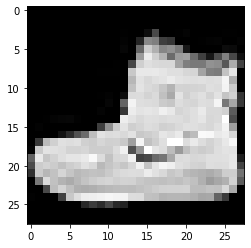

In [9]:
plt.imshow(x_train_all[0], cmap = 'gray')
plt.show

In [10]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [11]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [12]:
print(class_names[y_train_all[0]])

앵클부츠


In [13]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [14]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42 )

In [17]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [18]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [19]:
x_train = x_train /255
x_val = x_val /255

In [20]:
x_train = x_train.reshape(-1,784)
x_val = x_val.reshape(-1,784)

In [21]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [22]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit_transform([0,1,3,1])

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [23]:
tf.keras.utils.to_categorical([0,1,3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [25]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [26]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [27]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [37]:
fc = MultiClassNetwork(units = 100, batch_size = 256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

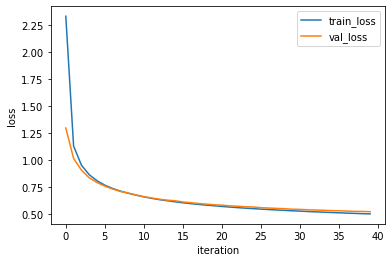

In [38]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [39]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

In [40]:
np.random.permutation(np.arange(12000)%10)

array([4, 6, 3, ..., 0, 6, 6])

In [41]:
np.sum(y_val == np.random.permutation(np.arange(12000)%10)) /12000

0.10325

## 07-2 텐서플로와 케라스를 소개합니다

In [42]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [43]:
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

In [44]:
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
history = model.fit(x_train, y_train_encoded, epochs=40, 
                    validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 1s 562us/step - loss: 1.3772 - accuracy: 0.6467 - val_loss: 0.9651 - val_accuracy: 0.7343
Epoch 2/40
1500/1500 [==============================] - 1s 505us/step - loss: 0.8444 - accuracy: 0.7427 - val_loss: 0.7520 - val_accuracy: 0.7592
Epoch 3/40
1500/1500 [==============================] - 1s 517us/step - loss: 0.7132 - accuracy: 0.7630 - val_loss: 0.6656 - val_accuracy: 0.7760
Epoch 4/40
1500/1500 [==============================] - 1s 503us/step - loss: 0.6496 - accuracy: 0.7780 - val_loss: 0.6152 - val_accuracy: 0.7905
Epoch 5/40
1500/1500 [==============================] - 1s 519us/step - loss: 0.6086 - accuracy: 0.7905 - val_loss: 0.5805 - val_accuracy: 0.8012
Epoch 6/40
1500/1500 [==============================] - 1s 509us/step - loss: 0.5788 - accuracy: 0.8010 - val_loss: 0.5536 - val_accuracy: 0.8088
Epoch 7/40
1500/1500 [==============================] - 1s 503us/step - loss: 0.5557 - accuracy: 0.8090 - val_loss: 0.5347 -

In [46]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


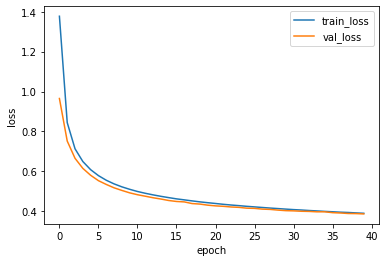

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

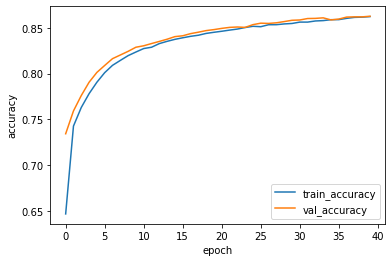

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [49]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)

In [50]:
print(accuracy)

0.862583339214325
